## MNIST DATA USING ANN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
from torch.utils.data import DataLoader 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='../data',train=True,download=True,transform=transform)
train_data

C:\Users\harsh\anaconda3\envs\pytorchenv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data = datasets.MNIST(root='../data',train=False,download=True,transform=transform) 
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

#### Examining

In [6]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [7]:
images,label = train_data[0]
print('Shape:', images.shape, 'Label:', label)

Shape: torch.Size([1, 28, 28]) Label: 5


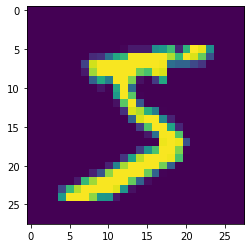

In [8]:
plt.imshow(images.reshape(28,28))

### Batch Loading

In [9]:
torch.manual_seed(101)

train_loader = DataLoader(train_data,batch_size=100,shuffle=True)
test_loader = DataLoader(test_data,batch_size=500,shuffle=False)

### Display the first 10 images

Labels:  [    7     2     3     5     8     5     3     6     9     9]


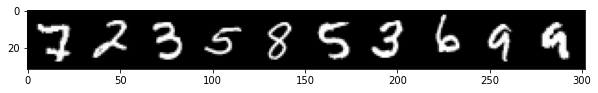

In [10]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:10].numpy())

# Print the first 12 images
im = make_grid(images[:10], nrow=10)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Building an ANN model

In [11]:
class MLP(nn.Module):
    def __init__(self,in_size=784,out_size=10,layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_size,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_size)
        
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [12]:
torch.manual_seed(101)
model = MLP()
model

MLP(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
for params in model.parameters():
    print(params.numel())

94080
120
10080
84
840
10


### Defining loss function

In [14]:
criterion= nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr =0.001)

### Training the model

In [15]:
import time
start_time = time.time()

epochs = 10

#TRACKERS
train_correct = []
test_correct = []
train_losses = []
test_losses = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    #Running the test batches
    for batch, (X_train,y_train) in enumerate(train_loader):
        batch+=1
        
        #Apply the model
        y_pred = model(X_train.view(100,-1)) #flattening the data
        loss = criterion(y_pred,y_train)
        
        #Evaluating the correct values
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
         # Update parameters
        optimizer.zero_grad()
        loss.backward()   #back propogation
        optimizer.step()
        
        if batch%200==0:
            acc = train_corr.item() * 100/ (100*batch)
            print(f'Epoch {i}  Batch:{batch}  Loss:{loss.item()} Accuracy:{acc}')
                  
    #Updating train loss and accuracy           
    train_losses.append(loss)
    train_correct.append(train_corr)
                  
    #Running for test batches
    with torch.no_grad():
        for batch, (X_test,y_test) in enumerate(test_loader):
            #Applying the model
            y_val = model(X_test.view(500,-1))  #flatten X_test
                  
            predicted = torch.max(y_val.data,1)[1]
            test_corr += (predicted==y_test).sum()
        
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(test_corr)
                  
total_time = time.time()-start_time
print(f'Duration: {total_time/60} mins')

Epoch 0  Batch:200  Loss:0.2356238216161728 Accuracy:83.245
Epoch 0  Batch:400  Loss:0.3533070683479309 Accuracy:87.5325
Epoch 0  Batch:600  Loss:0.13734400272369385 Accuracy:89.58166666666666
Epoch 1  Batch:200  Loss:0.24684995412826538 Accuracy:94.87
Epoch 1  Batch:400  Loss:0.14273887872695923 Accuracy:95.085
Epoch 1  Batch:600  Loss:0.0733654797077179 Accuracy:95.355
Epoch 2  Batch:200  Loss:0.08371470123529434 Accuracy:96.515
Epoch 2  Batch:400  Loss:0.06228962913155556 Accuracy:96.6125
Epoch 2  Batch:600  Loss:0.06475143879652023 Accuracy:96.705
Epoch 3  Batch:200  Loss:0.117899090051651 Accuracy:97.65
Epoch 3  Batch:400  Loss:0.05712112784385681 Accuracy:97.4775
Epoch 3  Batch:600  Loss:0.031934332102537155 Accuracy:97.48833333333333
Epoch 4  Batch:200  Loss:0.10764962434768677 Accuracy:98.09
Epoch 4  Batch:400  Loss:0.04543372616171837 Accuracy:97.97
Epoch 4  Batch:600  Loss:0.05657264590263367 Accuracy:97.99
Epoch 5  Batch:200  Loss:0.007679496891796589 Accuracy:98.39
Epoch 5 

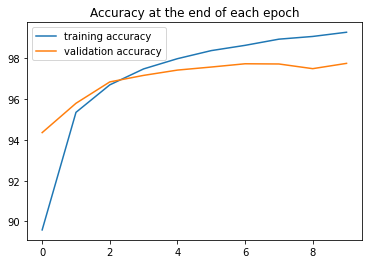

In [18]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [19]:
#NEW UNSEEN IMAGES
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9776/10000 =  97.760%
